# Monte Carlo with Gridworld

## Goal:

- How to implement Monte Carlo algorithm
- understandig caveats in RL

In [1]:
!git clone https://github.com/phizaz/chula_rl
%cd chula_rl
!pip install -e .

Cloning into 'chula_rl'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 12), reused 49 (delta 11), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/chula_rl
Obtaining file:///content/chula_rl
  Running setup.py develop for chula-rl


In [0]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: <class 'chula_rl.env.wrapper.ep_summary.EpisodeSummary'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


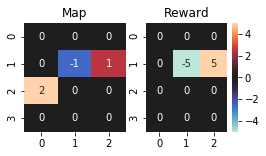

In [3]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()

## Step 2: Define policy

First-visit Monte Carlo + Policy iteration + Epsilon greedy

### Helper functions

In [0]:
def calculate_return(r, discount_factor):
    """return G for every time step given a sequence of rewards"""
    # code here ...
    g = np.zeros_like(r)
    for i in range(len(r)-1, -1, -1):
        if(i == len(r)-1):
            g[i] = r[i]
        else:
            g[i] = r[i] + g[i+1] * discount_factor
        
    return g

Test calculating return:

In [41]:
calculate_return(np.array([1., 1., 1., 1.]), 0.9)

array([3.439, 2.71 , 1.9  , 1.   ])

Expected result:

```
array([3.439, 2.71 , 1.9  , 1.   ])
```

In [0]:
def first_sa(s, a, g):
    """deduplicate (s, a) keeping only the first occurrances while also matching the corresponding returns"""
    # code here ...
    # ...
    # return unique sa and g
    # sa = tuple(first dim of s, second dim of s, a)
    # this is for numpy indexing!
    # ex: sa = ([0, 0], [0, 1], [1, 1])
    # means: s = [(0, 0), (0, 1)]; a = [1, 1]
    visit = []
    first_dim_s = []
    sec_dim_s = []
    a_n = []
    g_n = []
    
    for i, e in enumerate(s):
        if(not tuple(e) in visit):
            visit.append(tuple(e))
            first_dim_s.append(e[0])
            sec_dim_s.append(e[1])
            a_n.append(a[i])
            g_n.append(g[i])
    
    sa = (np.asarray(first_dim_s), np.asarray(sec_dim_s), np.asarray(a_n))
    return sa, g_n

Test first_sa:

In [60]:
s = np.array([
    [0, 0],
    [0, 1],
    [0, 0],
])
a = np.array([1, 1, 1])
g = np.array([1, 2, 3])
sa, g = first_sa(s, a, g)
print('sa:', sa)
print('g:', g)

sa: (array([0, 0]), array([0, 1]), array([1, 1]))
g: [1, 2]


Expected result:

```
sa: (array([0, 0]), array([0, 1]), array([1, 1]))
g: [1 2]
```

Note: The third state and action in sequence is a duplicate. Discarded.

### The policy: First-visit Monte Carlo with True Average

Note: there are many variants of MC, including:

- first or all visits
- true average or moving average

Here we concern ourselves with first-visit MC with true average

In [0]:
class MonteCarloPolicy(rl.policy.BasePolicy):
    """firt visit monte carlo with true average"""

    def __init__(self, discount_factor, observation_space, n_action):
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        # value tables
        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)
        self.cnt = np.zeros(self.q.shape, dtype=int)

    def step(self, state):
        return np.argmax(self.q[tuple(state)])  # greedy action selection

    def optimize_step(self, data):
        """update the action value (q) table with MC algorithm"""
        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        
        # code here ...
        # ...
        g_p = calculate_return(r, self.discount_factor)
        sa, g = first_sa(s, a, g_p)
        self.q[sa]=g

## Step 3: Define an explorer

In [0]:
policy = MonteCarloPolicy(discount_factor=0.99,
                          observation_space=env.observation_space,
                          n_action=env.action_space.n)

In [0]:
def run(policy, n_max_interaction):
    rl.util.set_seed(0) # predictable results
    env = make_env()
    explorer = rl.explorer.EpisodeExplorer(n_max_interaction=n_max_interaction, env=env)

    while True:
        try:
            data = explorer.step(policy)
            policy.optimize_step(data)  # not defined
        except rl.exception.InteractionExceeded:
            break
    df = pd.DataFrame(explorer.get_stats()['history'])
    return df

max: -20


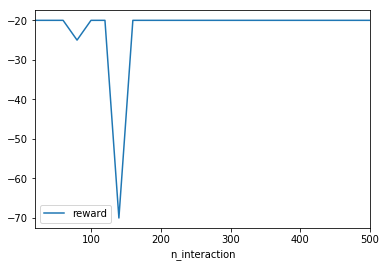

In [96]:
stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: Bad rewards (some -20 reward)

# Q1: Why we can't seem to learn a good policy?

Greedy policy makes the agent exploit learned episodes. The agent will not explore possibly better paths.

# Q2: Make changes to make the algorithm learn as expected

Hint: make the policy more random by adding a random wrapper on top of it 😉

In [0]:
class Wrapper(rl.policy.BasePolicyWrapper):
    """wraps around the policy to give the original policy some randomness"""
    def __init__(self, policy):
        self.policy = policy

    def step(self, state):
        # code here ...
        # ...
        epsilon = 0.3
        a = np.argmax(self.q[tuple(state)])  # greedy action selection
        prob = np.zeros(self.q.shape[-1], dtype=np.float)
        for i in range(len(prob)):
            if(i == a):
                prob[i] = 1 - epsilon + (epsilon/len(prob))
            else:
                prob[i] = epsilon/len(prob)

        return np.random.choice(len(prob), 1, p=prob)[0]

Test again:

max: 2


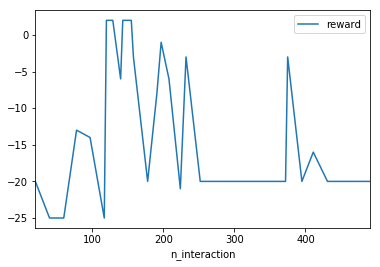

In [139]:
policy = MonteCarloPolicy(discount_factor=0.99,
                          observation_space=env.observation_space,
                          n_action=env.action_space.n)
policy = Wrapper(policy)


stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: You should get max reward close to 2 (much better than previously -21). If not you might want to tune your randomness.

# Q3: What is the theoretically maximum reward we could get under this setting with an optimal policy?

2

# Q4: What will happen in terms of learning if we change the move reward from -1 to 0? Why?

That is each move will not be penalized anymore.

There is tends to have more length of episode because agent is not penalized by taking more steps.

# Q6: After changing move reward to 0 what is now the theoretically maximum reward attainable?

5


# Q7: What would happen in terms of learning if we don't clip the episode?

There are possibly infinite loops in exploration steps.